In [61]:
%cd /data/codes/prep_ps_pykaldi/
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

import pickle
import json
import re

from torch.utils.data import DataLoader
from torch import nn

from src.dataset import PrepDataset
import os

/data/codes/prep_ps_pykaldi


In [62]:
def convert_score_to_color(score, YELLOW_GREEN=80/50, RED_YELLOW=30/50):
    if RED_YELLOW is not None:
        LABEL2ID = {"GREEN": 0, "YELLOW": 1, "RED":2}
        red_index = score < RED_YELLOW
        yellow_index = ((score >= RED_YELLOW).int() & (score < YELLOW_GREEN).int()).bool()
        green_index = score >= YELLOW_GREEN
    else:
        LABEL2ID = {"GREEN": 0, "YELLOW": 1, "RED":1}
        RED_YELLOW = 30/50
        red_index = score < RED_YELLOW
        yellow_index = ((score >= RED_YELLOW).int() & (score < YELLOW_GREEN).int()).bool()
        green_index = score >= YELLOW_GREEN


    score[red_index] = LABEL2ID["RED"]
    score[yellow_index] = LABEL2ID["YELLOW"]
    score[green_index] = LABEL2ID["GREEN"]

    return score

def load_data(data_dir):
    phone_ids = np.load(f'{data_dir}/phone_ids.npy')
    word_ids = np.load(f'{data_dir}/word_ids.npy')
    
    phone_scores = np.load(f'{data_dir}/phone_scores.npy')
    word_scores = np.load(f'{data_dir}/word_scores.npy')
    sentence_scores = np.load(f'{data_dir}/sentence_scores.npy')

    durations = np.load(f'{data_dir}/duration.npy')
    gops = np.load(f'{data_dir}/gop.npy')
    wavlm_features = np.load(f'{data_dir}/wavlm_features.npy')

    return phone_ids, word_ids, phone_scores, word_scores, sentence_scores, durations, gops, wavlm_features


In [63]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from src.model import GOPT

train_dir = "/data/codes/prep_ps_pykaldi/exp/sm/prep"

phone_ids, word_ids, phone_scores, word_scores, \
    sentence_scores, durations, gops, wavlm_features = load_data(train_dir)
trainset = PrepDataset(
    phone_ids, word_ids, 
    phone_scores, word_scores, sentence_scores, 
    durations, gops, wavlm_features
    )

trainloader = DataLoader(trainset, batch_size=8, shuffle=True, drop_last=False)

test_dir = "/data/codes/prep_ps_pykaldi/exp/sm/prep"
phone_ids, word_ids, phone_scores, word_scores, \
    sentence_scores, durations, gops, wavlm_features = load_data(test_dir)
testset = PrepDataset(
    phone_ids, word_ids, 
    phone_scores, word_scores, sentence_scores, 
    durations, gops, wavlm_features
    )

testloader = DataLoader(testset, batch_size=8, shuffle=False, drop_last=True)

In [64]:
embed_dim=32
num_heads=1
depth=3
input_dim=851
num_phone=62
max_length=128

lr=1e-3
weight_decay=5e-7
betas=(0.95, 0.999)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gopt_model = GOPT(
    embed_dim=embed_dim, num_heads=num_heads, 
    depth=depth, input_dim=input_dim, 
    max_length=max_length, num_phone=num_phone, dropout=0.1).to(device)

trainables = [p for p in gopt_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(
    trainables, lr, 
    weight_decay=weight_decay, 
    betas=betas
)

loss_fn = nn.MSELoss()

In [65]:
def valid_phn(predict, target):
    preds, targs = [], []

    for i in range(predict.shape[0]):
        for j in range(predict.shape[1]):
            if target[i, j] >= 0:
                preds.append(predict[i, j])
                targs.append(target[i, j])
    targs = np.array(targs)
    preds = np.array(preds)

    mse = np.mean((targs - preds) ** 2)
    mae = np.mean(np.abs(targs - preds))
    corr = np.corrcoef(preds, targs)[0, 1]
    return mse, mae, corr


In [66]:
def valid_wrd(predict, target, word_id):
    preds, targs = [], []

    for i in range(target.shape[0]):
        prev_w_id, start_id = 0, 0
        # for each token
        for j in range(target.shape[1]):
            cur_w_id = word_id[i, j].int()
            # if a new word
            if cur_w_id != prev_w_id:
                # average each phone belongs to the word
                preds.append(np.mean(predict[i, start_id: j].numpy(), axis=0))
                targs.append(np.mean(target[i, start_id: j].numpy(), axis=0))

                if cur_w_id == -1:
                    break
                else:
                    prev_w_id = cur_w_id
                    start_id = j

    preds = np.array(preds)
    targs = np.array(targs).round(2)

    word_mse = np.mean((preds - targs) ** 2)
    wrd_mae = np.mean(np.abs(preds - targs))
    word_corr = np.corrcoef(preds, targs)[0, 1]
    
    return word_mse, wrd_mae, word_corr

In [67]:
def valid_utt(predict, target):
    utt_mse = np.mean(((predict[:, 0] - target[:, 0]) ** 2).numpy())
    utt_mae = np.mean((np.abs(predict[:, 0] - target[:, 0])).numpy())
    
    utt_corr = np.corrcoef(predict[:, 0], target[:, 0])[0, 1]
    return utt_mse, utt_mae, utt_corr


In [68]:
def to_device(batch, device):
    features = batch["features"].to(device)
    phone_ids = batch["phone_ids"].to(device)
    word_ids = batch["word_ids"]
    
    phone_labels = batch["phone_scores"].to(device)
    word_labels = batch["word_scores"].to(device)
    utterance_labels = batch["sentence_scores"].to(device)

    return features, phone_ids, word_ids, phone_labels, word_labels, utterance_labels

def to_cpu(preds, labels):
    preds = preds.detach().cpu().squeeze(-1)
    labels = labels.detach().cpu()

    return preds, labels

In [69]:
def load_pred_and_label(pred_path, label_path):
    pred = np.load(pred_path)
    label = np.load(label_path)

    pred = np.concatenate(pred)
    label = np.concatenate(label)
    index = label != -1    
    
    return label[index], pred[index]

def save_confusion_matrix_figure(
        fig_path, pred_path, label_path, YELLOW_GREEN=80/50, RED_YELLOW=30/50):
    
    label, pred = load_pred_and_label(pred_path=pred_path, label_path=label_path)
    
    actual = convert_score_to_color(
        torch.from_numpy(label), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    
    predicted = convert_score_to_color(
        torch.from_numpy(pred), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    
    cfs_mtr = confusion_matrix(actual, predicted)
    cfs_mtr = cfs_mtr / cfs_mtr.sum(axis=1, keepdims=True)
    if RED_YELLOW is not None:
        cm_display = ConfusionMatrixDisplay(
            confusion_matrix = cfs_mtr, display_labels = ["GREEN", "YELLOW", "RED"])
    else:
        cm_display = ConfusionMatrixDisplay(
            confusion_matrix = cfs_mtr, display_labels = ["CORRECT", "INCORRECT"])

    plt.title("Confusion Matrix")
    cm_display.plot(cmap='Blues')
    plt.savefig(fig_path) 
    plt.close()

def save(epoch, output_dir, model, optimizer, phone_desicion_result, \
    phone_predicts, phone_labels, word_predicts, word_labels, utterance_predicts, utterance_labels):
    
    model_path = f'{output_dir}/model.pt'
    optimizer_path = f'{output_dir}/optimizer.pt'
    phone_desicion_result_path = f'{output_dir}/phone_result'

    phone_predict_path = f'{output_dir}/phn_pred.npy'
    phone_label_path = f'{output_dir}/phn_label.npy'
    word_predict_path = f'{output_dir}/wrd_pred.npy'
    word_label_path = f'{output_dir}/wrd_label.npy'
    utterance_predict_path = f'{output_dir}/utt_pred.npy'
    utterance_label_path = f'{output_dir}/utt_label.npy'

    three_class_fig_path = f'{output_dir}/confusion_matrix_three_class.png'
    two_class_fig_path = f'{output_dir}/confusion_matrix_two_class.png'

    with open(phone_desicion_result_path, "w") as f:
        f.write(phone_desicion_result)

    torch.save(model.state_dict(), model_path)
    torch.save(optimizer.state_dict(), optimizer_path)
    np.save(phone_predict_path, phone_predicts)
    np.save(phone_label_path, phone_labels)
    np.save(word_predict_path, word_predicts)
    np.save(word_label_path, word_labels)
    np.save(utterance_predict_path, utterance_predicts)
    np.save(utterance_label_path, utterance_labels)
    save_confusion_matrix_figure(three_class_fig_path, phone_predict_path, phone_label_path, YELLOW_GREEN=80/50, RED_YELLOW=30/50)
    save_confusion_matrix_figure(two_class_fig_path, phone_predict_path, phone_label_path, YELLOW_GREEN=80/50, RED_YELLOW=None)

    print(f'Save state dict and result to {output_dir}')

In [70]:
@torch.no_grad()
def validate(epoch, gopt_model, testloader, best_mse, ckpt_dir):
    gopt_model.eval()
    A_phn, A_phn_target = [], []
    A_utt, A_utt_target = [], []
    A_wrd, A_wrd_target, A_wrd_id = [], [], []

    for batch in testloader:
        features, phone_ids, word_ids, \
            phone_labels, word_labels, utterance_labels = to_device(batch, device)
        
        utterance_preds, phone_preds, word_preds = gopt_model(
            x=features.float(), phn=phone_ids.long())
        
        phone_preds, phone_labels = to_cpu(phone_preds, phone_labels)
        word_preds, word_labels = to_cpu(word_preds, word_labels)
        utterance_preds, utterance_labels = to_cpu(utterance_preds, utterance_labels)
        
        A_phn.append(phone_preds), A_phn_target.append(phone_labels)
        A_utt.append(utterance_preds), A_utt_target.append(utterance_labels)
        A_wrd.append(word_preds), A_wrd_target.append(word_labels), A_wrd_id.append(word_ids)
    
    # phone level
    A_phn, A_phn_target  = torch.vstack(A_phn), torch.vstack(A_phn_target)
    decision_result = calculate_phone_decision_result(A_phn, A_phn_target)

    # word level
    A_word, A_word_target, A_word_id = torch.vstack(A_wrd), torch.vstack(A_wrd_target), torch.vstack(A_wrd_id) 

    # utterance level
    A_utt, A_utt_target = torch.vstack(A_utt), torch.vstack(A_utt_target)

    # valid_token_mse, mae, corr
    phn_mse, phn_mae, phn_corr = valid_phn(A_phn, A_phn_target)
    word_mse, wrd_mae, word_corr = valid_wrd(A_word, A_word_target, A_word_id)
    utt_mse, utt_mae, utt_corr = valid_utt(A_utt, A_utt_target)

    if phn_mse < best_mse:
        best_mse = phn_mse
    ckpt_dir = f'{ckpt_dir}/ckpts-eph={epoch}-mse={round(phn_mse, 4)}'
    os.makedirs(ckpt_dir)
    
    save(
        epoch=epoch,
        output_dir=ckpt_dir, 
        model=gopt_model, 
        optimizer=optimizer, 
        phone_desicion_result=decision_result, 
        phone_predicts=A_phn.numpy(), 
        phone_labels=A_phn_target.numpy(), 
        word_predicts=A_word.numpy(), 
        word_labels=A_word_target.numpy(), 
        utterance_predicts=A_utt.numpy(), 
        utterance_labels=A_utt_target.numpy()
    )

    print(f"### Validation result (epoch={epoch})")
    print("  Phone level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} ".format(phn_mse, phn_mae, phn_corr))
    print("   Word level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} ".format(word_mse, wrd_mae, word_corr))
    print("    Utt level:  MSE={:.3f}  MAE={:.3f}  PCC={:.3f} ".format(utt_mse, utt_mae, utt_corr))

    return {
        "phn_mse": phn_mse, 
        "phn_mae": phn_mae,
        "phn_corr": phn_corr,
        "word_mse": word_mse,
        "wrd_mae": wrd_mae,
        "word_corr": word_corr,
        "utt_mse": utt_mse,
        "utt_mae": utt_mae,
        "utt_corr": utt_corr,
        "best_mse": best_mse
    }

def calculate_phone_decision_result(A_phn, A_phn_target):
    indices = A_phn_target != -1
    _label = A_phn_target[indices].clone()
    _pred = A_phn[indices].clone()

    converted_pred = convert_score_to_color(_pred).view(-1)
    converted_label = convert_score_to_color(_label).view(-1)

    result = classification_report(y_true=converted_label, y_pred=converted_pred)
    print("### F1 Score: \n", result)

    return result


In [71]:
def calculate_losses(phone_preds, phone_labels, word_preds, word_labels, utterance_preds, utterance_labels):
    # phone level
    mask = phone_labels >=0
    phone_preds = phone_preds.squeeze(2) * mask
    phone_labels = phone_labels * mask
    
    loss_phn = loss_fn(phone_preds, phone_labels)
    loss_phn = loss_phn * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)

    # utterance level
    loss_utt = loss_fn(utterance_preds.squeeze(1) ,utterance_labels)
    # loss_utt = torch.tensor(0)

    # word level
    mask = word_labels >= 0      
    word_preds = word_preds.squeeze(2) * mask
    word_labels = word_labels * mask
    
    loss_word = loss_fn(word_preds, word_labels)
    loss_word = loss_word * (mask.shape[0] * mask.shape[1]) / torch.sum(mask)
    # loss_word = torch.tensor(0)

    return loss_phn, loss_utt, loss_word

Training:   8%|▊         | 15/195 [00:00<00:01, 137.73it/s, loss=0.913, loss_phn=0.448, loss_utt=0.181, loss_word=0.284] 

Training: 100%|██████████| 195/195 [00:01<00:00, 138.44it/s, loss=0.49, loss_phn=0.233, loss_utt=0.102, loss_word=0.155]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.70      0.80     20125
         1.0       0.13      0.73      0.22      1722
         2.0       0.81      0.09      0.17      3111

    accuracy                           0.62     24958
   macro avg       0.63      0.51      0.40     24958
weighted avg       0.87      0.62      0.68     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=0-mse=0.24230000376701355
### Validation result (epoch=0)
  Phone level:  MSE=0.242  MAE=0.360  PCC=0.596 
   Word level:  MSE=0.193  MAE=0.383  PCC=0.581 
    Utt level:  MSE=0.090  MAE=0.252  PCC=0.688 


Training: 100%|██████████| 195/195 [00:01<00:00, 129.39it/s, loss=0.397, loss_phn=0.188, loss_utt=0.0642, loss_word=0.145] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.69      0.80     20125
         1.0       0.13      0.75      0.22      1722
         2.0       0.81      0.19      0.31      3111

    accuracy                           0.63     24958
   macro avg       0.63      0.54      0.44     24958
weighted avg       0.88      0.63      0.70     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=1-mse=0.23240000009536743
### Validation result (epoch=1)
  Phone level:  MSE=0.232  MAE=0.370  PCC=0.633 
   Word level:  MSE=0.156  MAE=0.302  PCC=0.631 
    Utt level:  MSE=0.087  MAE=0.244  PCC=0.714 


Training: 100%|██████████| 195/195 [00:01<00:00, 138.20it/s, loss=0.347, loss_phn=0.179, loss_utt=0.0379, loss_word=0.13]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     20125
         1.0       0.16      0.47      0.24      1722
         2.0       0.78      0.26      0.39      3111

    accuracy                           0.76     24958
   macro avg       0.62      0.53      0.51     24958
weighted avg       0.85      0.76      0.78     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=2-mse=0.21480000019073486
### Validation result (epoch=2)
  Phone level:  MSE=0.215  MAE=0.269  PCC=0.654 
   Word level:  MSE=0.160  MAE=0.284  PCC=0.672 
    Utt level:  MSE=0.074  MAE=0.205  PCC=0.744 


Training: 100%|██████████| 195/195 [00:01<00:00, 129.38it/s, loss=0.472, loss_phn=0.257, loss_utt=0.0485, loss_word=0.167]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.77      0.85     20125
         1.0       0.15      0.63      0.24      1722
         2.0       0.76      0.32      0.45      3111

    accuracy                           0.70     24958
   macro avg       0.62      0.57      0.51     24958
weighted avg       0.87      0.70      0.76     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=3-mse=0.21209999918937683
### Validation result (epoch=3)
  Phone level:  MSE=0.212  MAE=0.295  PCC=0.663 
   Word level:  MSE=0.136  MAE=0.282  PCC=0.685 
    Utt level:  MSE=0.053  MAE=0.183  PCC=0.764 


Training: 100%|██████████| 195/195 [00:01<00:00, 147.82it/s, loss=0.487, loss_phn=0.251, loss_utt=0.0877, loss_word=0.149]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88     20125
         1.0       0.17      0.58      0.26      1722
         2.0       0.83      0.25      0.38      3111

    accuracy                           0.74     24958
   macro avg       0.64      0.56      0.51     24958
weighted avg       0.87      0.74      0.78     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=4-mse=0.19820000231266022
### Validation result (epoch=4)
  Phone level:  MSE=0.198  MAE=0.273  PCC=0.681 
   Word level:  MSE=0.142  MAE=0.292  PCC=0.668 
    Utt level:  MSE=0.051  MAE=0.171  PCC=0.753 


Training: 100%|██████████| 195/195 [00:01<00:00, 135.14it/s, loss=0.331, loss_phn=0.175, loss_utt=0.0385, loss_word=0.117]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.82      0.87     20125
         1.0       0.16      0.60      0.26      1722
         2.0       0.81      0.30      0.44      3111

    accuracy                           0.74     24958
   macro avg       0.64      0.57      0.52     24958
weighted avg       0.87      0.74      0.78     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=5-mse=0.19380000233650208
### Validation result (epoch=5)
  Phone level:  MSE=0.194  MAE=0.273  PCC=0.689 
   Word level:  MSE=0.138  MAE=0.298  PCC=0.695 
    Utt level:  MSE=0.051  MAE=0.177  PCC=0.773 


Training: 100%|██████████| 195/195 [00:01<00:00, 144.62it/s, loss=0.395, loss_phn=0.237, loss_utt=0.0419, loss_word=0.116] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.93      0.88      0.90     20125
         1.0       0.18      0.51      0.27      1722
         2.0       0.83      0.29      0.43      3111

    accuracy                           0.78     24958
   macro avg       0.65      0.56      0.53     24958
weighted avg       0.86      0.78      0.80     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=6-mse=0.19110000133514404
### Validation result (epoch=6)
  Phone level:  MSE=0.191  MAE=0.251  PCC=0.700 
   Word level:  MSE=0.130  MAE=0.265  PCC=0.707 
    Utt level:  MSE=0.050  MAE=0.163  PCC=0.772 


Training: 100%|██████████| 195/195 [00:01<00:00, 130.10it/s, loss=0.264, loss_phn=0.11, loss_utt=0.056, loss_word=0.0975]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.93      0.86      0.90     20125
         1.0       0.17      0.53      0.26      1722
         2.0       0.83      0.28      0.42      3111

    accuracy                           0.77     24958
   macro avg       0.65      0.56      0.52     24958
weighted avg       0.87      0.77      0.79     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=7-mse=0.19249999523162842
### Validation result (epoch=7)
  Phone level:  MSE=0.192  MAE=0.259  PCC=0.700 
   Word level:  MSE=0.134  MAE=0.287  PCC=0.708 
    Utt level:  MSE=0.048  MAE=0.173  PCC=0.785 


Training: 100%|██████████| 195/195 [00:01<00:00, 146.61it/s, loss=0.308, loss_phn=0.136, loss_utt=0.049, loss_word=0.123]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.80      0.86     20125
         1.0       0.16      0.65      0.26      1722
         2.0       0.82      0.31      0.46      3111

    accuracy                           0.73     24958
   macro avg       0.64      0.59      0.53     24958
weighted avg       0.88      0.73      0.77     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=8-mse=0.18770000338554382
### Validation result (epoch=8)
  Phone level:  MSE=0.188  MAE=0.296  PCC=0.706 
   Word level:  MSE=0.139  MAE=0.297  PCC=0.693 
    Utt level:  MSE=0.071  MAE=0.218  PCC=0.796 


Training: 100%|██████████| 195/195 [00:01<00:00, 123.77it/s, loss=0.324, loss_phn=0.116, loss_utt=0.0645, loss_word=0.143]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.80      0.87     20125
         1.0       0.17      0.62      0.26      1722
         2.0       0.81      0.37      0.51      3111

    accuracy                           0.74     24958
   macro avg       0.64      0.60      0.55     24958
weighted avg       0.88      0.74      0.78     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=9-mse=0.18119999766349792
### Validation result (epoch=9)
  Phone level:  MSE=0.181  MAE=0.267  PCC=0.715 
   Word level:  MSE=0.150  MAE=0.334  PCC=0.718 
    Utt level:  MSE=0.055  MAE=0.192  PCC=0.787 


Training: 100%|██████████| 195/195 [00:01<00:00, 164.27it/s, loss=0.434, loss_phn=0.239, loss_utt=0.0633, loss_word=0.131]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.78      0.85     20125
         1.0       0.16      0.61      0.25      1722
         2.0       0.76      0.44      0.56      3111

    accuracy                           0.72     24958
   macro avg       0.62      0.61      0.55     24958
weighted avg       0.87      0.72      0.78     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=10-mse=0.18629999458789825
### Validation result (epoch=10)
  Phone level:  MSE=0.186  MAE=0.282  PCC=0.715 
   Word level:  MSE=0.147  MAE=0.324  PCC=0.716 
    Utt level:  MSE=0.053  MAE=0.188  PCC=0.807 


Training: 100%|██████████| 195/195 [00:01<00:00, 140.96it/s, loss=0.346, loss_phn=0.192, loss_utt=0.0095, loss_word=0.144]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.93      0.89      0.91     20125
         1.0       0.18      0.51      0.27      1722
         2.0       0.85      0.26      0.40      3111

    accuracy                           0.79     24958
   macro avg       0.65      0.55      0.53     24958
weighted avg       0.87      0.79      0.80     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=11-mse=0.18219999969005585
### Validation result (epoch=11)
  Phone level:  MSE=0.182  MAE=0.246  PCC=0.727 
   Word level:  MSE=0.125  MAE=0.264  PCC=0.732 
    Utt level:  MSE=0.047  MAE=0.163  PCC=0.812 


Training: 100%|██████████| 195/195 [00:01<00:00, 145.11it/s, loss=0.252, loss_phn=0.1, loss_utt=0.0532, loss_word=0.099]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.87      0.90     20125
         1.0       0.19      0.51      0.27      1722
         2.0       0.80      0.43      0.56      3111

    accuracy                           0.79     24958
   macro avg       0.64      0.60      0.58     24958
weighted avg       0.87      0.79      0.82     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=12-mse=0.16779999434947968
### Validation result (epoch=12)
  Phone level:  MSE=0.168  MAE=0.238  PCC=0.739 
   Word level:  MSE=0.121  MAE=0.264  PCC=0.732 
    Utt level:  MSE=0.039  MAE=0.153  PCC=0.819 


Training: 100%|██████████| 195/195 [00:01<00:00, 145.98it/s, loss=0.367, loss_phn=0.221, loss_utt=0.0214, loss_word=0.124]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.81      0.87     20125
         1.0       0.17      0.66      0.27      1722
         2.0       0.85      0.30      0.44      3111

    accuracy                           0.74     24958
   macro avg       0.66      0.59      0.53     24958
weighted avg       0.88      0.74      0.78     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=13-mse=0.17579999566078186
### Validation result (epoch=13)
  Phone level:  MSE=0.176  MAE=0.280  PCC=0.727 
   Word level:  MSE=0.128  MAE=0.283  PCC=0.723 
    Utt level:  MSE=0.043  MAE=0.160  PCC=0.823 


Training: 100%|██████████| 195/195 [00:01<00:00, 144.15it/s, loss=0.471, loss_phn=0.269, loss_utt=0.0438, loss_word=0.158]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.81      0.88     20125
         1.0       0.17      0.55      0.26      1722
         2.0       0.73      0.55      0.63      3111

    accuracy                           0.76     24958
   macro avg       0.62      0.64      0.59     24958
weighted avg       0.87      0.76      0.80     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=14-mse=0.17419999837875366
### Validation result (epoch=14)
  Phone level:  MSE=0.174  MAE=0.255  PCC=0.742 
   Word level:  MSE=0.127  MAE=0.287  PCC=0.733 
    Utt level:  MSE=0.039  MAE=0.150  PCC=0.832 


Training: 100%|██████████| 195/195 [00:01<00:00, 129.85it/s, loss=0.429, loss_phn=0.16, loss_utt=0.0937, loss_word=0.175]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.81      0.88     20125
         1.0       0.17      0.62      0.27      1722
         2.0       0.83      0.38      0.52      3111

    accuracy                           0.75     24958
   macro avg       0.65      0.61      0.55     24958
weighted avg       0.88      0.75      0.79     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=15-mse=0.17020000517368317
### Validation result (epoch=15)
  Phone level:  MSE=0.170  MAE=0.276  PCC=0.738 
   Word level:  MSE=0.135  MAE=0.304  PCC=0.723 
    Utt level:  MSE=0.033  MAE=0.136  PCC=0.849 


Training: 100%|██████████| 195/195 [00:01<00:00, 134.69it/s, loss=0.451, loss_phn=0.259, loss_utt=0.0367, loss_word=0.155]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     20125
         1.0       0.20      0.51      0.29      1722
         2.0       0.85      0.36      0.50      3111

    accuracy                           0.80     24958
   macro avg       0.66      0.59      0.57     24958
weighted avg       0.88      0.80      0.82     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=16-mse=0.1615999937057495
### Validation result (epoch=16)
  Phone level:  MSE=0.162  MAE=0.225  PCC=0.756 
   Word level:  MSE=0.110  MAE=0.245  PCC=0.759 
    Utt level:  MSE=0.041  MAE=0.149  PCC=0.825 


Training: 100%|██████████| 195/195 [00:01<00:00, 153.92it/s, loss=0.324, loss_phn=0.168, loss_utt=0.0228, loss_word=0.133]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     20125
         1.0       0.19      0.52      0.27      1722
         2.0       0.78      0.47      0.59      3111

    accuracy                           0.79     24958
   macro avg       0.64      0.62      0.59     24958
weighted avg       0.87      0.79      0.82     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=17-mse=0.15850000083446503
### Validation result (epoch=17)
  Phone level:  MSE=0.159  MAE=0.233  PCC=0.757 
   Word level:  MSE=0.109  MAE=0.251  PCC=0.762 
    Utt level:  MSE=0.035  MAE=0.147  PCC=0.842 


Training: 100%|██████████| 195/195 [00:01<00:00, 165.27it/s, loss=0.208, loss_phn=0.118, loss_utt=0.0199, loss_word=0.0701] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.92     20125
         1.0       0.20      0.51      0.29      1722
         2.0       0.84      0.41      0.55      3111

    accuracy                           0.81     24958
   macro avg       0.66      0.60      0.59     24958
weighted avg       0.88      0.81      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=18-mse=0.1550000011920929
### Validation result (epoch=18)
  Phone level:  MSE=0.155  MAE=0.220  PCC=0.767 
   Word level:  MSE=0.108  MAE=0.239  PCC=0.773 
    Utt level:  MSE=0.032  MAE=0.131  PCC=0.851 


Training: 100%|██████████| 195/195 [00:01<00:00, 137.65it/s, loss=0.181, loss_phn=0.0924, loss_utt=0.0162, loss_word=0.072] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.91     20125
         1.0       0.21      0.50      0.29      1722
         2.0       0.81      0.47      0.60      3111

    accuracy                           0.81     24958
   macro avg       0.65      0.62      0.60     24958
weighted avg       0.88      0.81      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=19-mse=0.15049999952316284
### Validation result (epoch=19)
  Phone level:  MSE=0.150  MAE=0.218  PCC=0.770 
   Word level:  MSE=0.106  MAE=0.230  PCC=0.767 
    Utt level:  MSE=0.029  MAE=0.136  PCC=0.867 


Training: 100%|██████████| 195/195 [00:01<00:00, 146.44it/s, loss=0.361, loss_phn=0.153, loss_utt=0.0593, loss_word=0.149]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.91      0.92     20125
         1.0       0.21      0.48      0.29      1722
         2.0       0.84      0.41      0.55      3111

    accuracy                           0.82     24958
   macro avg       0.66      0.60      0.59     24958
weighted avg       0.87      0.82      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=20-mse=0.15559999644756317
### Validation result (epoch=20)
  Phone level:  MSE=0.156  MAE=0.217  PCC=0.767 
   Word level:  MSE=0.118  MAE=0.227  PCC=0.767 
    Utt level:  MSE=0.046  MAE=0.155  PCC=0.861 


Training: 100%|██████████| 195/195 [00:01<00:00, 126.00it/s, loss=0.47, loss_phn=0.261, loss_utt=0.0475, loss_word=0.161]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     20125
         1.0       0.19      0.52      0.27      1722
         2.0       0.79      0.52      0.63      3111

    accuracy                           0.79     24958
   macro avg       0.64      0.63      0.60     24958
weighted avg       0.88      0.79      0.82     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=21-mse=0.15690000355243683
### Validation result (epoch=21)
  Phone level:  MSE=0.157  MAE=0.238  PCC=0.761 
   Word level:  MSE=0.114  MAE=0.266  PCC=0.758 
    Utt level:  MSE=0.031  MAE=0.141  PCC=0.860 


Training: 100%|██████████| 195/195 [00:01<00:00, 137.79it/s, loss=0.453, loss_phn=0.232, loss_utt=0.0408, loss_word=0.18]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.94      0.89      0.92     20125
         1.0       0.21      0.57      0.30      1722
         2.0       0.88      0.35      0.50      3111

    accuracy                           0.80     24958
   macro avg       0.68      0.60      0.57     24958
weighted avg       0.89      0.80      0.82     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=22-mse=0.14959999918937683
### Validation result (epoch=22)
  Phone level:  MSE=0.150  MAE=0.225  PCC=0.779 
   Word level:  MSE=0.102  MAE=0.224  PCC=0.778 
    Utt level:  MSE=0.029  MAE=0.127  PCC=0.890 


Training: 100%|██████████| 195/195 [00:01<00:00, 127.93it/s, loss=0.281, loss_phn=0.135, loss_utt=0.0259, loss_word=0.12]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     20125
         1.0       0.20      0.56      0.30      1722
         2.0       0.83      0.50      0.62      3111

    accuracy                           0.80     24958
   macro avg       0.66      0.64      0.61     24958
weighted avg       0.89      0.80      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=23-mse=0.14229999482631683
### Validation result (epoch=23)
  Phone level:  MSE=0.142  MAE=0.241  PCC=0.786 
   Word level:  MSE=0.101  MAE=0.224  PCC=0.782 
    Utt level:  MSE=0.029  MAE=0.127  PCC=0.891 


Training: 100%|██████████| 195/195 [00:01<00:00, 143.48it/s, loss=0.446, loss_phn=0.268, loss_utt=0.0275, loss_word=0.15]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     20125
         1.0       0.21      0.56      0.30      1722
         2.0       0.86      0.37      0.52      3111

    accuracy                           0.80     24958
   macro avg       0.67      0.61      0.58     24958
weighted avg       0.88      0.80      0.82     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=24-mse=0.14869999885559082
### Validation result (epoch=24)
  Phone level:  MSE=0.149  MAE=0.230  PCC=0.777 
   Word level:  MSE=0.121  MAE=0.282  PCC=0.758 
    Utt level:  MSE=0.036  MAE=0.144  PCC=0.871 


Training: 100%|██████████| 195/195 [00:01<00:00, 162.28it/s, loss=0.295, loss_phn=0.147, loss_utt=0.0262, loss_word=0.122]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91     20125
         1.0       0.20      0.52      0.29      1722
         2.0       0.83      0.51      0.63      3111

    accuracy                           0.80     24958
   macro avg       0.66      0.64      0.61     24958
weighted avg       0.88      0.80      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=25-mse=0.13899999856948853
### Validation result (epoch=25)
  Phone level:  MSE=0.139  MAE=0.230  PCC=0.790 
   Word level:  MSE=0.104  MAE=0.254  PCC=0.789 
    Utt level:  MSE=0.025  MAE=0.119  PCC=0.892 


Training: 100%|██████████| 195/195 [00:01<00:00, 147.47it/s, loss=0.218, loss_phn=0.113, loss_utt=0.0217, loss_word=0.0834]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.86      0.91     20125
         1.0       0.20      0.57      0.30      1722
         2.0       0.84      0.50      0.62      3111

    accuracy                           0.80     24958
   macro avg       0.66      0.64      0.61     24958
weighted avg       0.89      0.80      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=26-mse=0.1404999941587448
### Validation result (epoch=26)
  Phone level:  MSE=0.141  MAE=0.227  PCC=0.787 
   Word level:  MSE=0.101  MAE=0.247  PCC=0.788 
    Utt level:  MSE=0.023  MAE=0.110  PCC=0.900 


Training: 100%|██████████| 195/195 [00:01<00:00, 146.72it/s, loss=0.3, loss_phn=0.16, loss_utt=0.0184, loss_word=0.122]      


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.90      0.92     20125
         1.0       0.22      0.53      0.31      1722
         2.0       0.85      0.46      0.59      3111

    accuracy                           0.82     24958
   macro avg       0.67      0.63      0.61     24958
weighted avg       0.88      0.82      0.84     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=27-mse=0.13580000400543213
### Validation result (epoch=27)
  Phone level:  MSE=0.136  MAE=0.213  PCC=0.796 
   Word level:  MSE=0.098  MAE=0.229  PCC=0.799 
    Utt level:  MSE=0.027  MAE=0.122  PCC=0.892 


Training: 100%|██████████| 195/195 [00:01<00:00, 150.45it/s, loss=0.267, loss_phn=0.176, loss_utt=0.0151, loss_word=0.0756]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.85      0.90     20125
         1.0       0.20      0.56      0.29      1722
         2.0       0.81      0.59      0.68      3111

    accuracy                           0.80     24958
   macro avg       0.66      0.67      0.63     24958
weighted avg       0.89      0.80      0.83     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=28-mse=0.131400004029274
### Validation result (epoch=28)
  Phone level:  MSE=0.131  MAE=0.218  PCC=0.805 
   Word level:  MSE=0.104  MAE=0.251  PCC=0.785 
    Utt level:  MSE=0.027  MAE=0.135  PCC=0.903 


Training: 100%|██████████| 195/195 [00:01<00:00, 146.65it/s, loss=0.187, loss_phn=0.0841, loss_utt=0.0152, loss_word=0.088]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     20125
         1.0       0.21      0.57      0.31      1722
         2.0       0.85      0.51      0.64      3111

    accuracy                           0.81     24958
   macro avg       0.67      0.65      0.62     24958
weighted avg       0.89      0.81      0.84     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=29-mse=0.12970000505447388
### Validation result (epoch=29)
  Phone level:  MSE=0.130  MAE=0.214  PCC=0.805 
   Word level:  MSE=0.092  MAE=0.223  PCC=0.802 
    Utt level:  MSE=0.022  MAE=0.114  PCC=0.907 


Training: 100%|██████████| 195/195 [00:01<00:00, 125.04it/s, loss=0.309, loss_phn=0.144, loss_utt=0.0115, loss_word=0.154]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93     20125
         1.0       0.23      0.51      0.32      1722
         2.0       0.86      0.48      0.61      3111

    accuracy                           0.83     24958
   macro avg       0.68      0.63      0.62     24958
weighted avg       0.89      0.83      0.85     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=30-mse=0.1290999948978424
### Validation result (epoch=30)
  Phone level:  MSE=0.129  MAE=0.199  PCC=0.810 
   Word level:  MSE=0.091  MAE=0.217  PCC=0.821 
    Utt level:  MSE=0.025  MAE=0.119  PCC=0.917 


Training: 100%|██████████| 195/195 [00:01<00:00, 137.84it/s, loss=0.234, loss_phn=0.131, loss_utt=0.0198, loss_word=0.0835]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20125
         1.0       0.22      0.49      0.30      1722
         2.0       0.80      0.65      0.72      3111

    accuracy                           0.83     24958
   macro avg       0.66      0.67      0.65     24958
weighted avg       0.89      0.83      0.85     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=31-mse=0.12470000237226486
### Validation result (epoch=31)
  Phone level:  MSE=0.125  MAE=0.209  PCC=0.816 
   Word level:  MSE=0.096  MAE=0.246  PCC=0.807 
    Utt level:  MSE=0.017  MAE=0.103  PCC=0.926 


Training: 100%|██████████| 195/195 [00:01<00:00, 139.64it/s, loss=0.193, loss_phn=0.107, loss_utt=0.0226, loss_word=0.0633]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.93     20125
         1.0       0.23      0.50      0.32      1722
         2.0       0.87      0.45      0.59      3111

    accuracy                           0.84     24958
   macro avg       0.68      0.62      0.62     24958
weighted avg       0.89      0.84      0.85     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=32-mse=0.1264999955892563
### Validation result (epoch=32)
  Phone level:  MSE=0.127  MAE=0.199  PCC=0.819 
   Word level:  MSE=0.097  MAE=0.230  PCC=0.803 
    Utt level:  MSE=0.021  MAE=0.103  PCC=0.917 


Training: 100%|██████████| 195/195 [00:01<00:00, 156.92it/s, loss=0.228, loss_phn=0.116, loss_utt=0.0185, loss_word=0.0938]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93     20125
         1.0       0.24      0.45      0.31      1722
         2.0       0.81      0.62      0.70      3111

    accuracy                           0.84     24958
   macro avg       0.67      0.66      0.65     24958
weighted avg       0.88      0.84      0.86     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=33-mse=0.1234000027179718
### Validation result (epoch=33)
  Phone level:  MSE=0.123  MAE=0.189  PCC=0.817 
   Word level:  MSE=0.093  MAE=0.236  PCC=0.809 
    Utt level:  MSE=0.023  MAE=0.112  PCC=0.908 


Training: 100%|██████████| 195/195 [00:01<00:00, 149.19it/s, loss=0.303, loss_phn=0.133, loss_utt=0.0553, loss_word=0.115]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20125
         1.0       0.21      0.55      0.30      1722
         2.0       0.83      0.62      0.71      3111

    accuracy                           0.81     24958
   macro avg       0.67      0.68      0.64     24958
weighted avg       0.89      0.81      0.84     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=34-mse=0.12030000239610672
### Validation result (epoch=34)
  Phone level:  MSE=0.120  MAE=0.210  PCC=0.822 
   Word level:  MSE=0.086  MAE=0.212  PCC=0.820 
    Utt level:  MSE=0.019  MAE=0.103  PCC=0.916 


Training: 100%|██████████| 195/195 [00:01<00:00, 147.45it/s, loss=0.138, loss_phn=0.0773, loss_utt=0.00947, loss_word=0.0512]


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20125
         1.0       0.24      0.56      0.33      1722
         2.0       0.87      0.53      0.66      3111

    accuracy                           0.83     24958
   macro avg       0.69      0.67      0.64     24958
weighted avg       0.90      0.83      0.85     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=35-mse=0.1143999993801117
### Validation result (epoch=35)
  Phone level:  MSE=0.114  MAE=0.195  PCC=0.833 
   Word level:  MSE=0.086  MAE=0.222  PCC=0.831 
    Utt level:  MSE=0.017  MAE=0.098  PCC=0.930 


Training: 100%|██████████| 195/195 [00:01<00:00, 155.07it/s, loss=0.23, loss_phn=0.136, loss_utt=0.0164, loss_word=0.0775]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.87      0.91     20125
         1.0       0.21      0.51      0.30      1722
         2.0       0.81      0.65      0.72      3111

    accuracy                           0.82     24958
   macro avg       0.66      0.68      0.64     24958
weighted avg       0.89      0.82      0.85     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=36-mse=0.11860000342130661
### Validation result (epoch=36)
  Phone level:  MSE=0.119  MAE=0.205  PCC=0.825 
   Word level:  MSE=0.085  MAE=0.224  PCC=0.831 
    Utt level:  MSE=0.020  MAE=0.109  PCC=0.921 


Training: 100%|██████████| 195/195 [00:01<00:00, 176.96it/s, loss=0.16, loss_phn=0.0823, loss_utt=0.016, loss_word=0.0616]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20125
         1.0       0.24      0.47      0.31      1722
         2.0       0.81      0.69      0.75      3111

    accuracy                           0.84     24958
   macro avg       0.67      0.69      0.66     24958
weighted avg       0.89      0.84      0.86     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=37-mse=0.11020000278949738
### Validation result (epoch=37)
  Phone level:  MSE=0.110  MAE=0.184  PCC=0.839 
   Word level:  MSE=0.078  MAE=0.206  PCC=0.838 
    Utt level:  MSE=0.016  MAE=0.095  PCC=0.931 


Training: 100%|██████████| 195/195 [00:01<00:00, 132.68it/s, loss=0.233, loss_phn=0.121, loss_utt=0.0159, loss_word=0.0955]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.91      0.93     20125
         1.0       0.24      0.50      0.32      1722
         2.0       0.84      0.61      0.71      3111

    accuracy                           0.84     24958
   macro avg       0.68      0.67      0.65     24958
weighted avg       0.89      0.84      0.86     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=38-mse=0.11259999871253967
### Validation result (epoch=38)
  Phone level:  MSE=0.113  MAE=0.189  PCC=0.834 
   Word level:  MSE=0.082  MAE=0.198  PCC=0.842 
    Utt level:  MSE=0.018  MAE=0.096  PCC=0.930 


Training: 100%|██████████| 195/195 [00:01<00:00, 141.38it/s, loss=0.155, loss_phn=0.078, loss_utt=0.0114, loss_word=0.0655]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.93     20125
         1.0       0.25      0.51      0.34      1722
         2.0       0.85      0.61      0.71      3111

    accuracy                           0.85     24958
   macro avg       0.69      0.68      0.66     24958
weighted avg       0.89      0.85      0.86     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=39-mse=0.10580000281333923
### Validation result (epoch=39)
  Phone level:  MSE=0.106  MAE=0.183  PCC=0.845 
   Word level:  MSE=0.078  MAE=0.209  PCC=0.841 
    Utt level:  MSE=0.016  MAE=0.100  PCC=0.932 


Training: 100%|██████████| 195/195 [00:01<00:00, 136.74it/s, loss=0.176, loss_phn=0.0895, loss_utt=0.00745, loss_word=0.0785]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20125
         1.0       0.23      0.51      0.32      1722
         2.0       0.84      0.61      0.71      3111

    accuracy                           0.84     24958
   macro avg       0.67      0.67      0.65     24958
weighted avg       0.89      0.84      0.86     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=40-mse=0.11249999701976776
### Validation result (epoch=40)
  Phone level:  MSE=0.113  MAE=0.204  PCC=0.835 
   Word level:  MSE=0.085  MAE=0.235  PCC=0.842 
    Utt level:  MSE=0.018  MAE=0.106  PCC=0.926 


Training: 100%|██████████| 195/195 [00:01<00:00, 146.05it/s, loss=0.267, loss_phn=0.167, loss_utt=0.0163, loss_word=0.0838]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20125
         1.0       0.25      0.50      0.34      1722
         2.0       0.84      0.60      0.70      3111

    accuracy                           0.85     24958
   macro avg       0.68      0.67      0.66     24958
weighted avg       0.89      0.85      0.87     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=41-mse=0.10570000112056732
### Validation result (epoch=41)
  Phone level:  MSE=0.106  MAE=0.203  PCC=0.848 
   Word level:  MSE=0.078  MAE=0.191  PCC=0.840 
    Utt level:  MSE=0.022  MAE=0.107  PCC=0.928 


Training: 100%|██████████| 195/195 [00:01<00:00, 138.43it/s, loss=0.229, loss_phn=0.132, loss_utt=0.0147, loss_word=0.0829]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20125
         1.0       0.25      0.48      0.33      1722
         2.0       0.84      0.64      0.73      3111

    accuracy                           0.85     24958
   macro avg       0.68      0.68      0.67     24958
weighted avg       0.89      0.85      0.87     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=42-mse=0.10459999740123749
### Validation result (epoch=42)
  Phone level:  MSE=0.105  MAE=0.193  PCC=0.847 
   Word level:  MSE=0.071  MAE=0.186  PCC=0.855 
    Utt level:  MSE=0.015  MAE=0.095  PCC=0.943 


Training: 100%|██████████| 195/195 [00:01<00:00, 132.31it/s, loss=0.223, loss_phn=0.148, loss_utt=0.00666, loss_word=0.0689]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     20125
         1.0       0.30      0.46      0.36      1722
         2.0       0.88      0.57      0.69      3111

    accuracy                           0.87     24958
   macro avg       0.71      0.66      0.67     24958
weighted avg       0.90      0.87      0.88     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=43-mse=0.10300000011920929
### Validation result (epoch=43)
  Phone level:  MSE=0.103  MAE=0.166  PCC=0.856 
   Word level:  MSE=0.077  MAE=0.185  PCC=0.860 
    Utt level:  MSE=0.024  MAE=0.118  PCC=0.939 


Training: 100%|██████████| 195/195 [00:01<00:00, 131.74it/s, loss=0.199, loss_phn=0.114, loss_utt=0.0185, loss_word=0.0666]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     20125
         1.0       0.28      0.48      0.35      1722
         2.0       0.87      0.59      0.70      3111

    accuracy                           0.86     24958
   macro avg       0.70      0.67      0.67     24958
weighted avg       0.90      0.86      0.87     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=44-mse=0.10170000046491623
### Validation result (epoch=44)
  Phone level:  MSE=0.102  MAE=0.176  PCC=0.854 
   Word level:  MSE=0.075  MAE=0.198  PCC=0.855 
    Utt level:  MSE=0.020  MAE=0.106  PCC=0.941 


Training: 100%|██████████| 195/195 [00:01<00:00, 137.12it/s, loss=0.127, loss_phn=0.0752, loss_utt=0.0124, loss_word=0.0398] 


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20125
         1.0       0.27      0.48      0.34      1722
         2.0       0.84      0.71      0.77      3111

    accuracy                           0.86     24958
   macro avg       0.69      0.70      0.68     24958
weighted avg       0.90      0.86      0.88     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=45-mse=0.094200000166893
### Validation result (epoch=45)
  Phone level:  MSE=0.094  MAE=0.186  PCC=0.865 
   Word level:  MSE=0.075  MAE=0.207  PCC=0.848 
    Utt level:  MSE=0.013  MAE=0.091  PCC=0.944 


Training: 100%|██████████| 195/195 [00:01<00:00, 135.59it/s, loss=0.208, loss_phn=0.133, loss_utt=0.00459, loss_word=0.0704]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20125
         1.0       0.29      0.50      0.37      1722
         2.0       0.87      0.63      0.73      3111

    accuracy                           0.87     24958
   macro avg       0.70      0.69      0.68     24958
weighted avg       0.90      0.87      0.88     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=46-mse=0.09390000253915787
### Validation result (epoch=46)
  Phone level:  MSE=0.094  MAE=0.169  PCC=0.866 
   Word level:  MSE=0.073  MAE=0.205  PCC=0.860 
    Utt level:  MSE=0.014  MAE=0.090  PCC=0.946 


Training: 100%|██████████| 195/195 [00:01<00:00, 149.40it/s, loss=0.205, loss_phn=0.119, loss_utt=0.00456, loss_word=0.0815]  


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     20125
         1.0       0.30      0.42      0.35      1722
         2.0       0.87      0.59      0.70      3111

    accuracy                           0.88     24958
   macro avg       0.71      0.66      0.67     24958
weighted avg       0.89      0.88      0.88     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=47-mse=0.10350000113248825
### Validation result (epoch=47)
  Phone level:  MSE=0.103  MAE=0.168  PCC=0.853 
   Word level:  MSE=0.077  MAE=0.193  PCC=0.854 
    Utt level:  MSE=0.019  MAE=0.104  PCC=0.938 


Training: 100%|██████████| 195/195 [00:01<00:00, 138.33it/s, loss=0.275, loss_phn=0.149, loss_utt=0.0288, loss_word=0.0973]   


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20125
         1.0       0.26      0.48      0.34      1722
         2.0       0.83      0.72      0.77      3111

    accuracy                           0.86     24958
   macro avg       0.69      0.70      0.68     24958
weighted avg       0.90      0.86      0.88     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=48-mse=0.09269999712705612
### Validation result (epoch=48)
  Phone level:  MSE=0.093  MAE=0.182  PCC=0.867 
   Word level:  MSE=0.067  MAE=0.194  PCC=0.867 
    Utt level:  MSE=0.016  MAE=0.100  PCC=0.942 


Training: 100%|██████████| 195/195 [00:01<00:00, 150.57it/s, loss=0.288, loss_phn=0.137, loss_utt=0.0351, loss_word=0.116]    


### F1 Score: 
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20125
         1.0       0.26      0.53      0.35      1722
         2.0       0.86      0.67      0.75      3111

    accuracy                           0.85     24958
   macro avg       0.69      0.70      0.68     24958
weighted avg       0.90      0.85      0.87     24958

Save state dict and result to /data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old/ckpts-eph=49-mse=0.0925000011920929
### Validation result (epoch=49)
  Phone level:  MSE=0.093  MAE=0.176  PCC=0.866 
   Word level:  MSE=0.062  MAE=0.180  PCC=0.874 
    Utt level:  MSE=0.013  MAE=0.089  PCC=0.944 


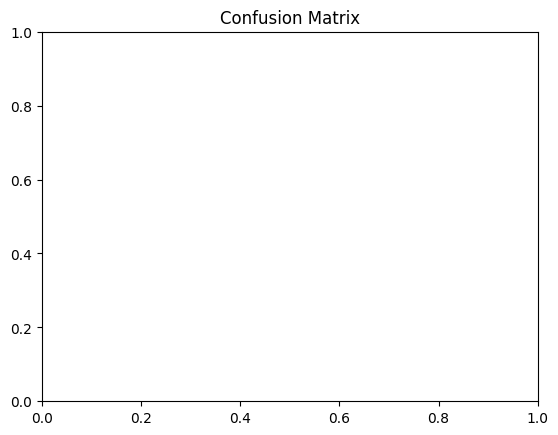

In [72]:
global_step = 0
best_mse = 1e5
num_epoch = 50 
phone_weight = 1.0
word_weight = 1.0
utterance_weight = 1.0
ckpt_dir = '/data/codes/prep_ps_pykaldi/exp/ckpts/in_long_old'

for epoch in range(num_epoch):
    gopt_model.train()
    train_tqdm = tqdm(trainloader, "Training")
    for batch in train_tqdm:
        optimizer.zero_grad()

        features, phone_ids, word_ids, \
            phone_labels, word_labels, utterance_labels = to_device(batch, device)

        utterance_preds, phone_preds, word_preds = gopt_model(
            x=features.float(), phn=phone_ids.long())
        
        loss_phn, loss_utt, loss_word = calculate_losses(
            phone_preds=phone_preds, 
            phone_labels=phone_labels, 
            word_preds=word_preds, 
            word_labels=word_labels, 
            utterance_preds=utterance_preds, 
            utterance_labels=utterance_labels)

        # total loss
        loss = phone_weight*loss_phn + word_weight*loss_word + utterance_weight*loss_utt
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gopt_model.parameters(), 1.0)
        
        optimizer.step()
        
        global_step += 1
        train_tqdm.set_postfix(
            loss=loss.item(), 
            loss_phn=loss_phn.item(), 
            loss_word=loss_word.item(), 
            loss_utt=loss_utt.item())
    
    valid_result = validate(
        epoch=epoch, 
        gopt_model=gopt_model, 
        testloader=testloader, 
        best_mse=best_mse, 
        ckpt_dir=ckpt_dir)
    
    best_mse = valid_result["best_mse"]
